In [ ]:
# !pip install gymnasium

# Imports

In [7]:
# Configuraciones
from collections import defaultdict

# Las de siempre
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Aprendizaje por Refuerzo
import gymnasium as gym  # https://gymnasium.farama.org/index.html

# Del Punto A al Punto B

# Gymnasium (Gym)

In [ ]:
env_keys = gym.envs.registry.keys()

for key in env_keys:
    print(key)

print('------------------')
print('Total de entornos:', len(env_keys))

# Cartpole

# Blackjack

![](https://gymnasium.farama.org/_images/blackjack_AE_loop_dark.png)

## Funcionamiento

In [ ]:
# env = gym.make('Blackjack-v1',
#                #nat = False # Otorga recompensa si el jugador empieza con 21.
#                sab = True, # Si el jugador tiene 21 y el dealer también, es un empate. http://www.incompleteideas.net/book/RLbook2020.pdf
#                )

# env.reset()

In [1]:
from env.blackjack import BlackjackEnv

env = BlackjackEnv()
env.reset()

((11, 7, False), {})

In [2]:
observation, info = env.reset(seed = 0)
print(observation[0], ': Jugador')
print(observation[1], ': Dealer')
print(observation[2], ': Hay algún as "utilizable"')

11 : Jugador
10 : Dealer
False : Hay algún as "utilizable"


In [3]:
# Elegimos una acción aleatoria
action = env.action_space.sample()

# 0 = stand (nos quedamos con el valor que tenemos)
# 1 = hit (pedimos una carta más)

action

0

In [4]:
observation, reward, terminated, truncated, info = env.step(action)

print(action, observation, terminated, reward)

0 (11, 19, False) True -1.0


## Agente

In [5]:
from agent.blackjack import BlackjackAgent

In [8]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(learning_rate=learning_rate,
                       initial_epsilon=start_epsilon,
                       epsilon_decay=epsilon_decay,
                       final_epsilon=final_epsilon,)

### Entrenamiento

In [9]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:25<00:00, 3955.20it/s]


### Análisis

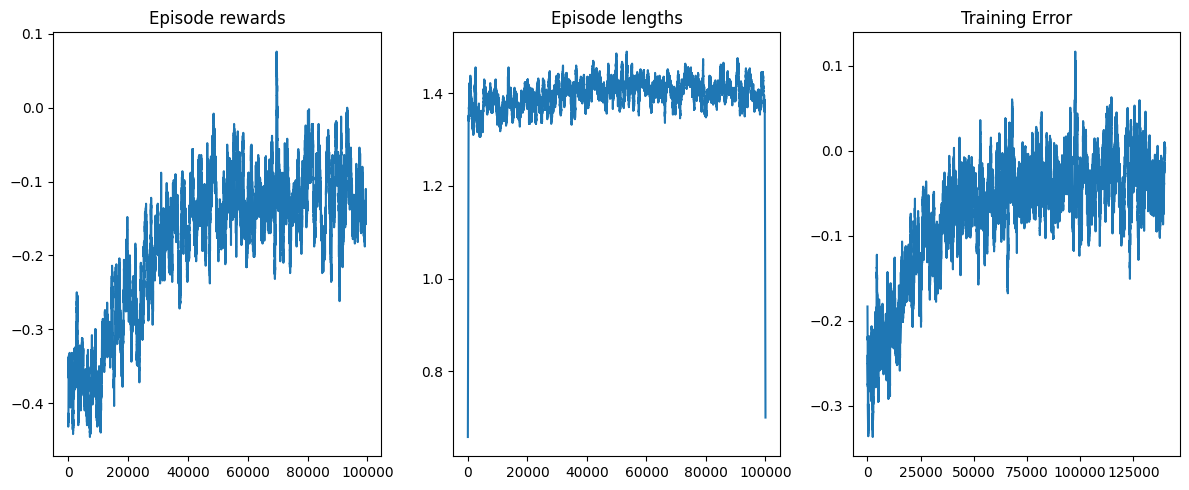

In [10]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

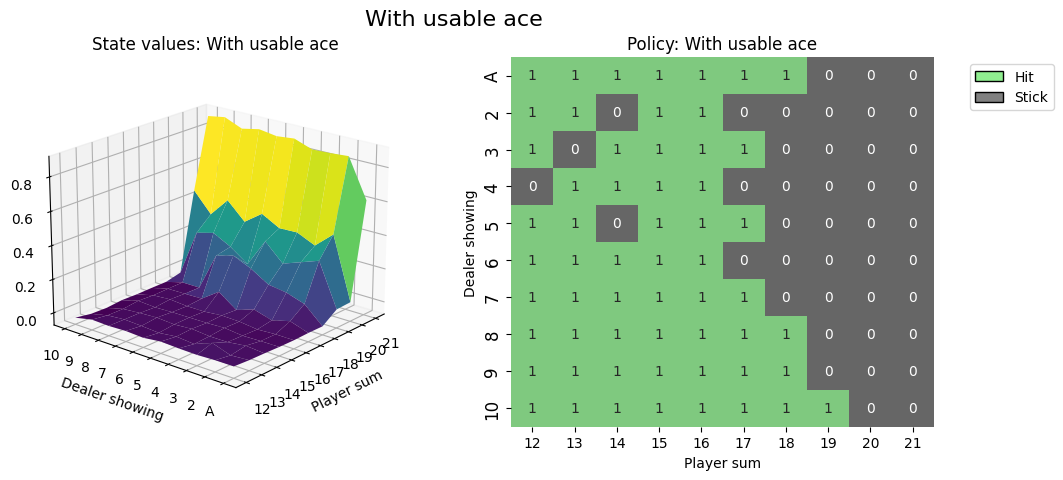

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

# Pruebas

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

def train_and_visualize(env_name, num_timesteps=10000):
    # Crear el entorno
    env = gym.make(env_name)

    # Envolver el entorno con la VecEnv para compatibilidad con SB3
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Crear el modelo PPO
    model = PPO("MlpPolicy", env, verbose=1)

    # Entrenar el modelo
    model.learn(total_timesteps=num_timesteps)

    # Visualizar el agente entrenado
    visualize_agent(env, model)

def visualize_agent(env, model, num_episodes=5):
    # Visualizar el agente entrenado
    rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0

        while True:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)

    # Plotear las recompensas de los episodios
    plt.plot(rewards, marker='o')
    plt.title('Recompensas de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.show()

if __name__ == "__main__":
    # Entrenar y visualizar el agente en el entorno CartPole-v1
    train_and_visualize("CartPole-v1", num_timesteps=10000)

In [ ]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

def train_and_visualize(env_name, num_timesteps=10000):
    # Crear el entorno
    env = gym.make(env_name)
    # Crear un objeto Monitor para manejar el renderizado y la recopilación de estadísticas
    env = Monitor(env, 'logs/')

    # Envolver el entorno con la VecEnv para compatibilidad con SB3
    from stable_baselines3.common.vec_env import DummyVecEnv
    env = DummyVecEnv([lambda: env])

    # Crear el modelo PPO
    model = PPO("MlpPolicy", env, verbose=1)

    # Entrenar el modelo
    model.learn(total_timesteps=num_timesteps)

    # Visualizar el agente entrenado
    visualize_agent(env, model)

def visualize_agent(env, model, num_episodes=5):
    # Visualizar el agente entrenado
    rewards = []

    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0

        while True:
            # Renderizar el entorno
            env.render()

            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)

    # Plotear las recompensas de los episodios
    plt.plot(rewards, marker='o')
    plt.title('Recompensas de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.show()

    # Cerrar el entorno después de visualizar
    env.close()

if __name__ == "__main__":
    # Entrenar y visualizar el agente en el entorno CartPole-v1
    train_and_visualize("CartPole-v1", num_timesteps=10000)

Inicialización: Inicializamos la tabla Q, que es una matriz donde las filas representan estados y las columnas representan acciones. Inicialmente, los valores en esta tabla pueden ser aleatorios.

Elección de Acción: Para cada episodio, observamos el estado actual y elegimos una acción. La elección de la acción puede ser determinista o basada en una política de exploración, que se introduce con el parámetro epsilon.

Interacción con el Entorno: Tomamos la acción elegida y observamos la recompensa del entorno. También observamos el nuevo estado.

Actualización de Q-Value: Actualizamos el valor Q para la acción tomada en el estado actual utilizando la fórmula de actualización de Q:

In [ ]:
Q[state, action] = Q[state, action] + learning_rate * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])

* learning_rate es la tasa de aprendizaje.
* gamma es el factor de descuento que representa la importancia de las recompensas futuras.
* Gamma : Este parámetro controla la importancia de las recompensas futuras. Un valor más alto significa que se dará más peso a las recompensas a largo plazo.
* Epsilon: Este parámetro controla la probabilidad de elegir una acción aleatoria en lugar de la mejor acción según la tabla Q. A medida que epsilon disminuye con el tiempo, el agente tiende a explotar más y explorar menos.

In [ ]:
actions = ['left', 'right']
epsilon = 0.9
alpha = 0.1
gamma = 0.9
max_episodes = 1000

In [ ]:
def build_q_table(n_states, actions):
    table = pd.DataFrame(np.zeros((n_states, len(actions))),
                         columns = actions)
    return table